In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import add, sub

In [2]:
from pyspark import SparkContext

sc.stop()

sc = SparkContext("local", "App Name", pyFiles=['C:/Users/Maxence/Desktop/Mapper.py'])

sc.setSystemProperty('spark.executor.memory', '2g')
sc.setSystemProperty('spark.executor.cores', '4')

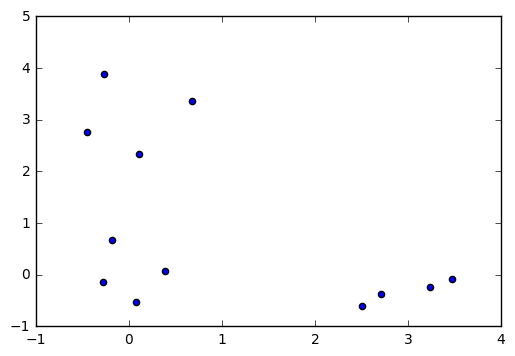

In [3]:
# Temporary cell. To be deleted later

N = 4
x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.txt", sep="\t", header=None, index=True)

In [3]:
#Convert RDD to DataFrame
from pyspark.sql.types import *
sql_c = SQLContext(sc)

lines = sc.textFile("gaussian_data.csv")
parts = lines.map(lambda l: l.split("\t"))

#Convert each field into int / float for DataFame implementation
data = parts.map(lambda p: (int(p[0]), float(p[1]), float(p[2])))

#DataFrame structure generation
spark_data = sql_c.createDataFrame(data, schema=("index","x1","x2"))

#Enable cartesian products. If not, Spark blocks 
sql_c.setConf("spark.sql.crossJoin.enabled", True)

#createOrReplaceTempView creates a view of DataFrame. Allows to use SQL queries over DataFrame
spark_data.createOrReplaceTempView("data")
spark_data.printSchema()

root
 |-- index: long (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)



In [7]:
spark_data.show()

+-----+--------------------+--------------------+
|index|                  x1|                  x2|
+-----+--------------------+--------------------+
|    0| 0.29354767383937447|  0.4568056073684831|
|    1|-0.12124833116822087|  0.5752018260995152|
|    2| 0.12483458806722963| 0.05885954111875446|
|    3|-0.15259069394378327|-0.03033431797640859|
|    4|   4.024687578015456|-0.06000651655121...|
|    5|   3.257188478127214| -0.6338546652028731|
|    6|  2.9208445305373254|-0.09815585513762597|
|    7|   3.654916033718488| 0.46443393112851783|
|    8|  0.3961357113708628|  3.0348860538467664|
|    9|-0.36549091419397184|   2.733579893500002|
|   10| -0.9850700857682828|   3.009768190648289|
|   11| -0.6293522535439434|   2.546469901438722|
+-----+--------------------+--------------------+



In [4]:
def generateSimilarityMatrix():
    #Cartesain product
    cartesian_similarities = sql_c.sql("SELECT d1.index as x1_index, d2.index as x2_index, -((d1.x1 - d2.x1) * (d1.x1 - d2.x1)) as similarity_x1, -((d1.x2 - d2.x2) * (d1.x2 - d2.x2)) as similarity_x2  FROM data d1 JOIN data d2")
    
    #View of cartesian product
    cartesian_similarities.createOrReplaceTempView("cartesian_similarities")
    
    #Sum of similarities and view generation
    sum_similarites = sql_c.sql("SELECT x1_index, x2_index, (similarity_x1 + similarity_x2) as similarity_without_diagonal FROM cartesian_similarities")
    sum_similarites.createOrReplaceTempView("sum_similarites")

    #Median computation
    sum_similarites_without_diagonal = sql_c.sql("SELECT *  FROM sum_similarites HAVING similarity_without_diagonal != 0")
    sum_similarites_without_diagonal.createOrReplaceTempView("sum_similarites_without_diagonal")
    median = np.median(sql_c.sql("SELECT similarity_without_diagonal FROM sum_similarites_without_diagonal").collect())
    
    #Replace diagonal of similarity matrix by median
    similarity_matrix = sql_c.sql("SELECT x1_index, x2_index, if(similarity_without_diagonal=0, '%s', similarity_without_diagonal) as similarities FROM sum_similarites" % median)
    similarity_matrix.createOrReplaceTempView("Similarity_matrix")

    return similarity_matrix

generateSimilarityMatrix()

DataFrame[x1_index: bigint, x2_index: bigint, similarities: string]

In [5]:
def initializeAvailibityAndResponsibilityMatrices(N):

    # Create A and R matrices
    A = sc.parallelize(range(N)).flatMap(lambda x: [(x, y, 0) for y in range(N)])
    R = sc.parallelize(range(N)).flatMap(lambda x: [(x, y, 0) for y in range(N)])

    # Each line is converted to corresponding format (int or float)
    A = A.map(lambda p: (int(p[0]), int(p[1]), float(p[2])))
    R = R.map(lambda p: (int(p[0]), int(p[1]), float(p[2])))

    # Apply the schema to the DataFrame
    A_spark = sql_c.createDataFrame(A, schema=("x1_index","x2_index","availability"))
    R_spark = sql_c.createDataFrame(R, schema=("x1_index","x2_index","responsibility"))

    #SQL views generation
    A_spark.createOrReplaceTempView("availability_matrix")
    R_spark.createOrReplaceTempView("responsibility_matrix")
    
    return A_spark, R_spark

initializeAvailibityAndResponsibilityMatrices(N)

(DataFrame[x1_index: bigint, x2_index: bigint, availability: double],
 DataFrame[x1_index: bigint, x2_index: bigint, responsibility: double])

In [6]:
def computeR(): #computeR(A, R, S, N)
    
    # Compute the sum of A and S
    sum_A_S = sql_c.sql("SELECT t.x1_index, t.x2_index, sum(t.sim_availability) as sim_availability FROM(SELECT  x1_index, x2_index, similarities as sim_availability FROM similarity_matrix UNION ALL SELECT x1_index, x2_index, availability as sim_availability FROM availability_matrix)t GROUP BY t.x1_index, t.x2_index ORDER BY t.x1_index, t.x2_index") 
    sum_A_S.createOrReplaceTempView("sum_A_S")

    # Remove all rows where i == k and compute the maximum
    sum_A_S_cartesian = sql_c.sql("SELECT  d.index, s.x2_index, s.x1_index, s.sim_availability FROM data d JOIN sum_A_S s WHERE d.index != s.x2_index")
    sum_A_S_cartesian.createOrReplaceTempView("sum_A_S_cartesian")
    maximum = sql_c.sql("SELECT x1_index, index, max(sim_availability) as maximum FROM sum_A_S_cartesian GROUP BY x1_index, index")
    maximum.createOrReplaceTempView("maximum")

    # Compute r
    responsibility_matrix_updated = sql_c.sql("SELECT x1_index, x2_index, sum(r_value) as r FROM (SELECT x1_index, x2_index, similarities as r_value FROM Similarity_matrix UNION ALL SELECT x1_index, index as x2_index, maximum*(-1) as r_value FROM maximum)t GROUP BY t.x1_index, t.x2_index")
    responsibility_matrix_updated.createOrReplaceTempView("responsibility_matrix_updated")
    
    # Compute R
    R_updated = sql_c.sql("SELECT rmu.x1_index, rmu.x2_index, ((1 - 0.5)* rmu.r) + (0.5 * rm.responsibility) as responsibility FROM responsibility_matrix rm JOIN responsibility_matrix_updated rmu ON rm.x1_index = rmu.x1_index AND rm.x2_index = rmu.x2_index") #% lambdaValue  
    R_updated.createOrReplaceTempView("responsibility_matrix")
    
    return R_updated

In [7]:
def computeA():
   
    # Remove all rows where i == k and compute the maximum
    tmp = sql_c.sql("SELECT * FROM responsibility_matrix WHERE x1_index != x2_index")
    tmp.createOrReplaceTempView("tmp")
    tmp_bis = sql_c.sql("SELECT d.index, ru.* FROM data d JOIN tmp ru")
    tmp_bis.createOrReplaceTempView("tmp_bis")
    tmp_ter = sql_c.sql("SELECT * FROM tmp_bis WHERE index != x1_index AND index != x2_index")
    tmp_ter.createOrReplaceTempView("tmp_ter")
    tmp_2 = sql_c.sql("SELECT index, x2_index, x1_index FROM tmp_ter")
    tmp_2.createOrReplaceTempView("tmp_2")
    tmp_2_bis = sql_c.sql("SELECT t.*, ru.responsibility FROM tmp_2 t JOIN responsibility_matrix ru ON ru.x1_index = t.index AND ru.x2_index = t.x2_index")
    tmp_2_bis.createOrReplaceTempView("tmp_2_bis")
    maximum = sql_c.sql("SELECT x1_index, x2_index, sum(if(responsibility < 0, 0, responsibility)) as sum_max_responsibility FROM tmp_2_bis GROUP BY x1_index, x2_index")
    maximum.createOrReplaceTempView("maximum_compute_A")
 
    # Add R[k, k]
    tmp_add = sql_c.sql("SELECT max.x2_index, max.x2_index, max.x1_index, max.x2_index, max.sum_max_responsibility, ru.responsibility FROM maximum_compute_A max JOIN responsibility_matrix ru ON ru.x1_index = max.x2_index AND ru.x2_index = max.x2_index WHERE ru.x1_index = ru.x2_index")
    tmp_add.createOrReplaceTempView("tmp_add")
    a = sql_c.sql("SELECT x1_index, x2_index, if((sum_max_responsibility + responsibility) > 0, 0, sum_max_responsibility + responsibility) as min_sum FROM tmp_add")
    a.createOrReplaceTempView("a")
    
    # Compute the value of a when i == k
    R_filter = sql_c.sql("SELECT * FROM responsibility_matrix WHERE x1_index = x2_index")
    R_filter.createOrReplaceTempView("R_filter")
    tmp_max2 = sql_c.sql("SELECT d.index, f.* FROM data d JOIN R_filter f WHERE d.index != f.x2_index")
    tmp_max2.createOrReplaceTempView("tmp_max2")
    tmp_max2_bis = sql_c.sql("SELECT t.index, t.x2_index, t.x1_index, ru.responsibility FROM tmp_max2 t JOIN responsibility_matrix ru ON ru.x1_index = t.index AND ru.x2_index = t.x2_index")
    tmp_max2_bis.createOrReplaceTempView("tmp_max2_bis")
    max_2 = sql_c.sql("SELECT x1_index, x2_index, sum(if(responsibility <0, 0, responsibility)) as min_sum FROM tmp_max2_bis GROUP BY x1_index, x2_index")
    max_2.createOrReplaceTempView("max_2")

    # Join both DataFrames
    union = sql_c.sql("SELECT * FROM a UNION ALL SELECT * FROM max_2")
    union.createOrReplaceTempView("union")

    # Compute A
    A_updated = sql_c.sql("SELECT u.x1_index, u.x2_index, ((1 - 0.5) * u.min_sum) + (0.5 * a.availability) as availability FROM availability_matrix a JOIN union u ON u.x1_index = a.x1_index AND u.x2_index = a.x2_index")
    A_updated.createOrReplaceTempView("availability_matrix")
    
    return A_updated

In [ ]:
import time

# Start the timer
startTime = time.time()

iterations = 10
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR()
    
    # Actually execute the code
    A = computeA()

R_final = R.collect()
A_final = A.collect()

print("Exec: --- %s seconds ---" % (time.time() - startTime))

0 iterations done
2 iterations done


In [27]:
A_matrix = np.zeros((N, N))
R_matrix = np.zeros((N, N))

for item in A_final:
    A_matrix[item[0], item[1]] = item[2]
    
for item in R_final:
    R_matrix[item[0], item[1]] = item[2] 

# Combine both a(i, k) and r(i, k) to get centers
centers = [i for i in range(N) if R_matrix[i, i] + A_matrix[i, i] > 0]

[]

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X[:,0], X[:,1], s=10, c='b', marker="s", label='data')
ax1.scatter(X[centers,0],X[centers,1], s=30, c='r', marker="o", label='centroids')
plt.legend(loc='upper right');
plt.show()